In [1]:
import os

import pandas as pd
import numpy as np

from dotenv import load_dotenv
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_absolute_error, median_absolute_error

# Grab covid data

In [2]:
dotenv_path = os.path.join(
    os.path.dirname(os.path.abspath('.')),
    '.env'
)
load_dotenv(dotenv_path, verbose=True)
conn_string = os.getenv('DATABASE_URL')
engine = create_engine(conn_string)

In [3]:
%load_ext sql

%sql $conn_string

### Grab all covid state data

In [4]:
sql = """
SELECT f.date_id, f.location_id, cases, recoveries, deaths, 
    cases_100k, testing_rate, hospitalization_rate,
    date, year, month, day_of_week, day_of_month,
    country, state, city, latitude, longitude, population
FROM covid_facts f JOIN date_dim d ON d.date_id = f.date_id
JOIN location_dim l ON l.location_id = f.location_id
WHERE country = 'US' AND city IS NULL
ORDER BY state
"""

us_df = pd.read_sql(sql, engine)

### Remove rows with null population

In [5]:
us_df = us_df.loc[pd.notnull(us_df.population)]

# Add region information for each state

In [6]:
states_df = pd.read_csv('https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv')
states_df = states_df.rename(columns=lambda col: col.lower())

In [7]:
us2_df = us_df.join(states_df.set_index('state'), on='state').sort_values(['state', 'date'])

### Normalize Features based on region population

In [8]:
us_northeast_df = us2_df[us2_df.region == 'Northeast']
us_south_df = us2_df[us2_df.region == 'South']
us_midwest_df = us2_df[us2_df.region == 'Midwest']
us_west_df = us2_df[us2_df.region == 'West']

In [9]:
us_northeast_df['cases_norm100k'] = us_northeast_df.cases / (us_northeast_df.population / 100_000)
us_northeast_df['recoveries_norm100k'] = us_northeast_df.recoveries / (us_northeast_df.population / 100_000)
us_northeast_df['deaths_norm100k'] = us_northeast_df.deaths / (us_northeast_df.population / 100_000)
us_south_df['cases_norm100k'] = us_south_df.cases / (us_south_df.population / 100_000)
us_south_df['recoveries_norm100k'] = us_south_df.recoveries / (us_south_df.population / 100_000)
us_south_df['deaths_norm100k'] = us_south_df.deaths / (us_south_df.population / 100_000)
us_midwest_df['cases_norm100k'] = us_midwest_df.cases / (us_midwest_df.population / 100_000)
us_midwest_df['recoveries_norm100k'] = us_midwest_df.recoveries / (us_midwest_df.population / 100_000)
us_midwest_df['deaths_norm100k'] = us_midwest_df.deaths / (us_midwest_df.population / 100_000)
us_west_df['cases_norm100k'] = us_west_df.cases / (us_west_df.population / 100_000)
us_west_df['recoveries_norm100k'] = us_west_df.recoveries / (us_west_df.population / 100_000)
us_west_df['deaths_norm100k'] = us_west_df.deaths / (us_west_df.population / 100_000)

### Combine normalized data and remove rows that will not be used in our model

In [10]:
us3_df = us_northeast_df.append(us_south_df.append(us_midwest_df).append(us_west_df))
us3_df = us3_df.drop(['year','month', 'country', 'state code', 'cases_100k', 'day_of_week', 'region', 'hospitalization_rate', 'longitude', 'division', 'location_id', 'day_of_month', 'city', 'latitude'], axis = 1)
us3_df.head()

,date_id,cases,recoveries,deaths,testing_rate,date,state,population,cases_norm100k,recoveries_norm100k,deaths_norm100k
2015,49,2,0.0,0.0,NaN,2020-03-10,Connecticut,3565287.0,0.056096,0.0,0.0
1993,50,3,0.0,0.0,NaN,2020-03-11,Connecticut,3565287.0,0.084145,0.0,0.0
2009,51,5,0.0,0.0,NaN,2020-03-12,Connecticut,3565287.0,0.140241,0.0,0.0
1926,52,11,0.0,0.0,NaN,2020-03-13,Connecticut,3565287.0,0.308531,0.0,0.0
1864,53,22,0.0,0.0,NaN,2020-03-14,Connecticut,3565287.0,0.617061,0.0,0.0


# This function itterates through each state and creates the feature set
#### groups data by state
#### based on 15 days worth of data, what is the actual number of cases in 7 days

In [38]:
def sliding_window(df, segment_time_frame, days_out):
    X = pd.DataFrame()
    y = []
    groups = df.groupby('state')
    for name, group in groups:
        loop_count = 0
        print(name)
        data_df = pd.DataFrame()
        for index, row in group.sort_values('date').drop(['state','date'], axis = 1).iterrows():
            data_df = data_df.append(row)
            if data_df.shape[0] >= segment_time_frame:
                #Calculate Features
                features = {}
                features['state'] = name
                features['date'] = group.date[index]
                for column in data_df.columns:
                    if column not in ['state', 'date']:
                        features['Max_' + column] = data_df[column].max()
                        features['Min_' + column] = data_df[column].min()
                        features['AVG_' + column] = data_df[column].mean()
                        if segment_time_frame > 1:
                            features[column + '_2'] = data_df[column].values[-1] - data_df[column].values[-2]
                            if segment_time_frame >= 3:
                                features[column + '_3'] = data_df[column].values[-1] - data_df[column].values[-3]
                                if segment_time_frame >= 5:
                                    features[column + '_5'] = data_df[column].values[-1] - data_df[column].values[-5]
                                    if segment_time_frame >= 7:
                                        features[column + '_7'] = data_df[column].values[-1] - data_df[column].values[-7]
                                        if segment_time_frame >= 8:
                                            features[column + '_' + str(segment_time_frame)] = data_df[column].values[-1] - data_df[column].values[-segment_time_frame]
                #Append Features
                X = X.append(features, ignore_index = True)
                data_df = data_df.iloc[1:,:]
                try:
                    y.append(list(group.sort_values('date').cases)[loop_count + days_out])
                except:
                    y.append(-1)
            loop_count = loop_count + 1
    return X.iloc[:, :], y[:]

In [39]:
X, y = sliding_window(us3_df, 15, 7)
print(X.head(22))
y[:5]

Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
District of Columbia
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming
      AVG_cases  AVG_cases_norm100k  AVG_date_id  AVG_deaths  \
0   1689.066667           34.448357         67.4   47.000000   
1   2007.933333           40.951613         69.8   57.200000   
2   2339.400000           47.711844         72.2   67.666667   
3   2682.800000           54.715455         74.6   78.533333   
4   3041.133333           62.023630         77.0   90.733333   
5   3418.000000           69.709791         79.4  103.800000   
6   3808.200000           77.667883         81.8  117.26666

[6092, 6274, 6475, 6621, 6820]

In [40]:
print(X.shape)
print(len([val for val in y if val == -1]))
for column in X.columns:
    if X[column].isnull().values.all():
        print(column)


(12316, 74)
357


In [41]:
#X2 = X2.drop([''], axis = 1)
X2 = X.fillna(X.mean())
X2['Target'] = y
print(X2.shape)
X_val, X2 = X2[X2['Target'] == -1], X2[X2['Target'] != -1]
print(X_val.shape)
y_val, X_val, y2, X2 = X_val['Target'], X_val.drop('Target', axis = 1), X2['Target'], X2.drop('Target', axis = 1), 

(12316, 75)
(357, 75)


In [42]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = .25)
print([column for column in X_train.columns if column not in ['date', 'state']])
transformed_X_train = pd.DataFrame(Normalizer().fit_transform(X_train[[column for column in X_train.columns if column not in ['date', 'state']]]), columns = [column for column in X_train.columns if column not in ['date', 'state']]) + 1
transformed_X_test = pd.DataFrame(Normalizer().transform(X_test[[column for column in X_test.columns if column not in ['date', 'state']]]), columns = [column for column in X_train.columns if column not in ['date', 'state']]) + 1

selected_col_idx = SelectKBest(chi2, k = 15).fit(transformed_X_train, y_train).get_support(indices = True)
selected_X_train = transformed_X_train.iloc[:, selected_col_idx]
selected_X_test = transformed_X_test.iloc[:, selected_col_idx]

['AVG_cases', 'AVG_cases_norm100k', 'AVG_date_id', 'AVG_deaths', 'AVG_deaths_norm100k', 'AVG_population', 'AVG_recoveries', 'AVG_recoveries_norm100k', 'AVG_testing_rate', 'Max_cases', 'Max_cases_norm100k', 'Max_date_id', 'Max_deaths', 'Max_deaths_norm100k', 'Max_population', 'Max_recoveries', 'Max_recoveries_norm100k', 'Max_testing_rate', 'Min_cases', 'Min_cases_norm100k', 'Min_date_id', 'Min_deaths', 'Min_deaths_norm100k', 'Min_population', 'Min_recoveries', 'Min_recoveries_norm100k', 'Min_testing_rate', 'cases_15', 'cases_2', 'cases_3', 'cases_5', 'cases_7', 'cases_norm100k_15', 'cases_norm100k_2', 'cases_norm100k_3', 'cases_norm100k_5', 'cases_norm100k_7', 'date_id_15', 'date_id_2', 'date_id_3', 'date_id_5', 'date_id_7', 'deaths_15', 'deaths_2', 'deaths_3', 'deaths_5', 'deaths_7', 'deaths_norm100k_15', 'deaths_norm100k_2', 'deaths_norm100k_3', 'deaths_norm100k_5', 'deaths_norm100k_7', 'population_15', 'population_2', 'population_3', 'population_5', 'population_7', 'recoveries_15', '

In [52]:
new_selected_X_train = selected_X_train.drop(['AVG_testing_rate', 'testing_rate_5', 'testing_rate_7', 'testing_rate_15', 'Max_testing_rate', 'Max_cases', 'Min_cases', 'Max_recoveries', 'Min_recoveries'], axis = 1)
new_selected_X_test = selected_X_test.drop(['AVG_testing_rate', 'testing_rate_5', 'testing_rate_7', 'testing_rate_15', 'Max_testing_rate', 'Max_cases', 'Min_cases', 'Max_recoveries', 'Min_recoveries'], axis = 1)
corr_matrix = new_selected_X_train.corr('spearman')
for row_idx, row in corr_matrix.iterrows():
    for col_idx, cor in row.iteritems():
        if col_idx != row_idx and cor > .8:
            print(str(row_idx) + ' ' + str(col_idx) + ' = ' + str(corr_matrix.loc[row_idx, col_idx]))
print(new_selected_X_train.columns)

Index(['AVG_cases', 'AVG_recoveries', 'Min_testing_rate', 'cases_15',
       'recoveries_15', 'testing_rate_3'],
      dtype='object')


In [53]:
reg = linear_model.LinearRegression().fit(new_selected_X_train, y_train)
coef = {}
for idx, name in enumerate(new_selected_X_train.columns):
    coef[name] = reg.coef_[idx]
print(coef)

{'AVG_cases': 21651423.69338786, 'AVG_recoveries': -8279403.952562299, 'Min_testing_rate': -4941117.478858683, 'cases_15': -9825656.489581563, 'recoveries_15': -11549936.76792692, 'testing_rate_3': -369682.7262282848}


In [54]:
y_pred = reg.predict(new_selected_X_test)
print("The Explained Variance: %.2f" % reg.score(new_selected_X_test, y_test))
print("The Mean Absolute Error: %.2f cases" % mean_absolute_error(y_test, y_pred))
print("The Median Absolute Error: %.2f cases" % median_absolute_error(y_test, y_pred))

The Explained Variance: 0.38
The Mean Absolute Error: 74554.54 cases
The Median Absolute Error: 37540.43 cases


In [79]:
X_predictors = X2[['AVG_cases', 'AVG_recoveries', 'Min_testing_rate', 'cases_15', 'recoveries_15', 'testing_rate_3']]
transformed_X_predictors = pd.DataFrame(Normalizer().fit_transform(X_predictors), columns = X_predictors.columns) + 1


In [80]:
reg2 = linear_model.LinearRegression().fit(transformed_X_predictors, y2)
coef = {}
for idx, name in enumerate(X3.columns):
    coef[name] = reg.coef_[idx]
print(coef)

{'AVG_cases': 21651423.69338786, 'AVG_recoveries': -8279403.952562299, 'Min_testing_rate': -4941117.478858683, 'cases_15': -9825656.489581563, 'recoveries_15': -11549936.76792692, 'testing_rate_3': -369682.7262282848}


In [81]:
X_val_date, X_val_state, X_val_predictors = X_val['date'], X_val['state'], X_val[['AVG_cases', 'AVG_recoveries', 'Min_testing_rate', 'cases_15', 'recoveries_15', 'testing_rate_3']]
X_val_predictors_processed = pd.DataFrame(Normalizer().transform(X_val_predictors), columns = X_val_predictors.columns) + 1
y_pred = reg.predict(X_val_predictors_processed)
print(y_pred)

[ 9259148.79777031  9120170.26639414  9005592.71652439  8884675.75628308
  8743725.1601086  11275918.9427581  11276931.23642761  -691968.83983515
  -666251.08040319  -607772.62265453  -525846.56634795  -463482.36248747
  -402897.81467919  -376575.87748784 17190930.62135608 17107114.41936957
 17104222.13963431 17179967.44185477 16934363.57990968 16965154.67577883
 16894786.78982119  6730320.02935804  6733656.21770914  6755341.07864166
  6786521.89544307  6806394.83702277  6934055.69233334  6893721.12268587
 18920848.2902456  18830334.05932362 18660366.93836651 18595428.1833781
 18563973.52043739 18429799.0401689  18251210.74101396 16110758.21034143
 16251578.51693156 16370735.15945962 16427591.98206238 16515746.45610382
 16611850.05909711 16738382.29482439 11900847.11337184 12056671.40077527
 12204397.86098883 11898735.28297372 11884971.44429692 11971271.69947235
 11952999.78907515  2062170.89075925  2059955.15398552  2046700.34420944
  2090000.47328661  2169475.84276229  2225178.985020

In [82]:
prediction_df = pd.DataFrame()
prediction_df['date'] = X_val_date + pd.Timedelta(days = 7)
print(prediction_df.shape)
print(X_val_date.shape)
prediction_df['state'] = X_val_state
prediction_df['cases'] = y_pred
prediction_df['category'] = ['Prediction' for column in X_val_date]
final_df = us2_df[['date', 'state', 'cases']]
final_df['category'] = 'Actual'
final_df = final_df.append(prediction_df)
final_df = final_df.sort_values(by = ['state', 'date'])
final_df.tail(22)

(357, 1)
(357,)


,date,state,cases,category
14978,2020-11-30,Wyoming,3.330500e+04,Actual
14985,2020-12-01,Wyoming,3.380500e+04,Actual
15025,2020-12-02,Wyoming,3.449100e+04,Actual
15143,2020-12-03,Wyoming,3.504600e+04,Actual
15054,2020-12-04,Wyoming,3.567700e+04,Actual
15024,2020-12-05,Wyoming,3.586600e+04,Actual
15131,2020-12-06,Wyoming,3.621800e+04,Actual
14959,2020-12-07,Wyoming,3.686700e+04,Actual
14977,2020-12-08,Wyoming,3.733900e+04,Actual
15140,2020-12-09,Wyoming,3.788500e+04,Actual


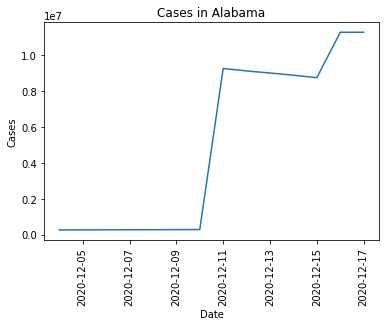

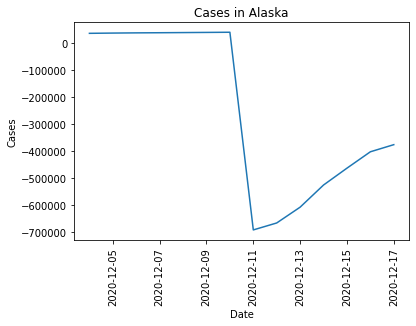

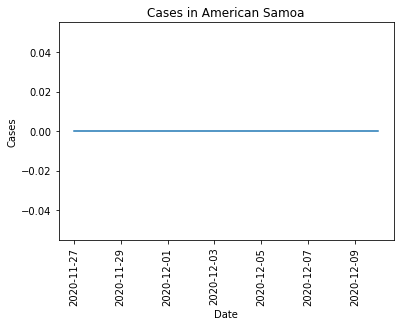

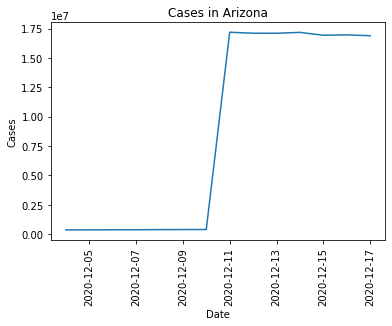

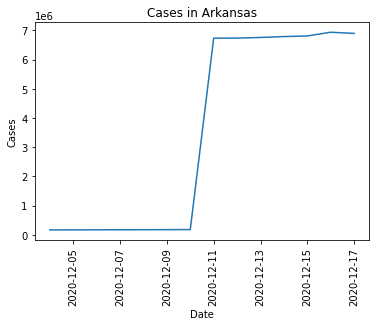

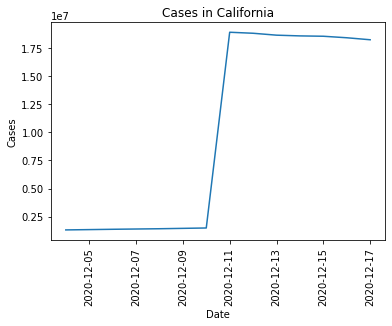

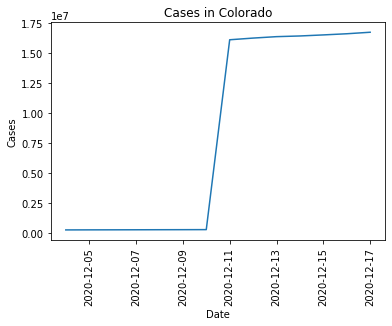

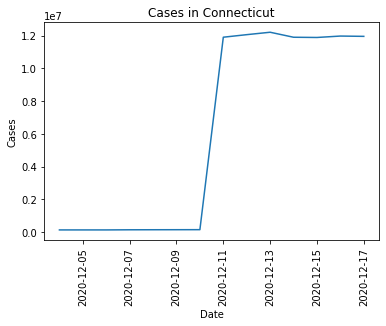

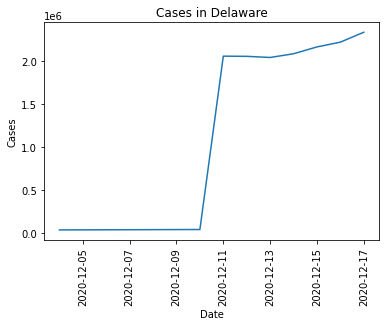

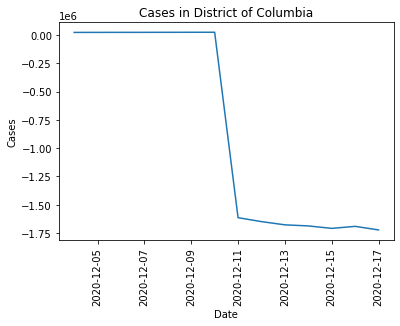

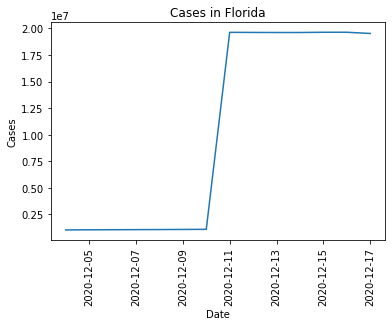

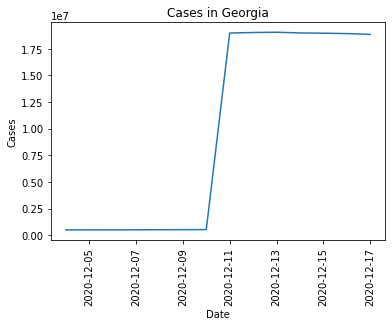

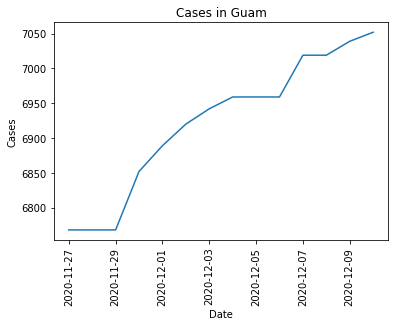

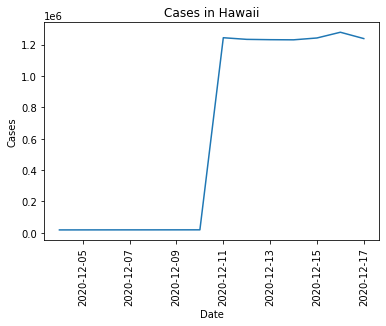

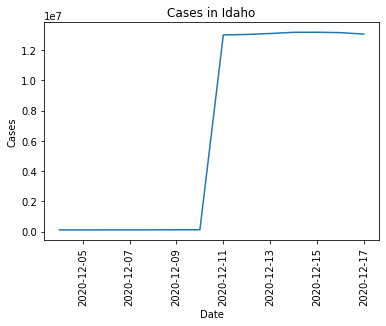

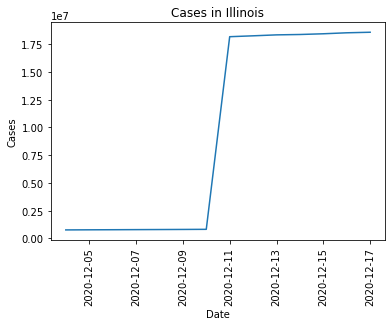

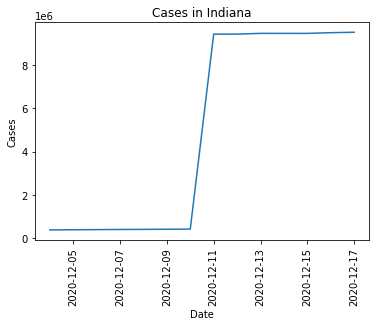

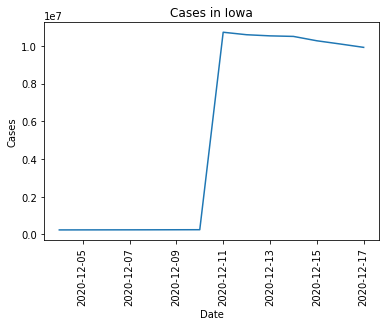

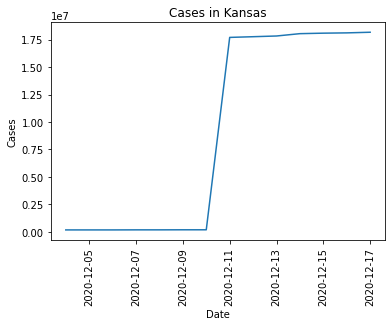

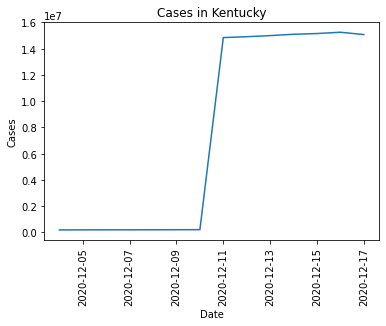

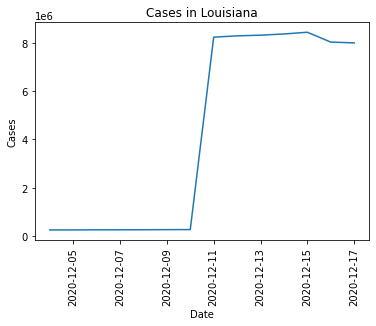

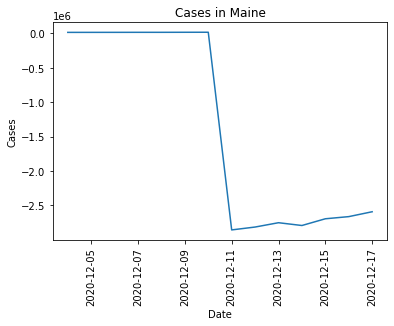

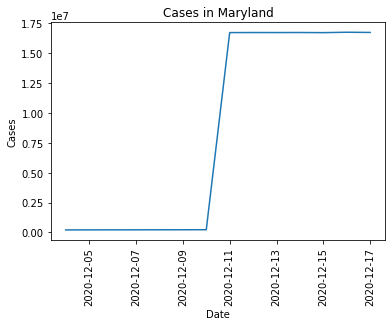

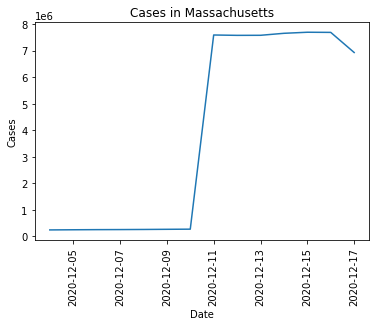

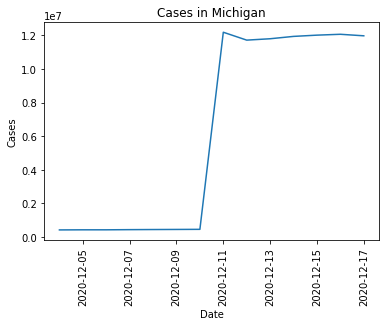

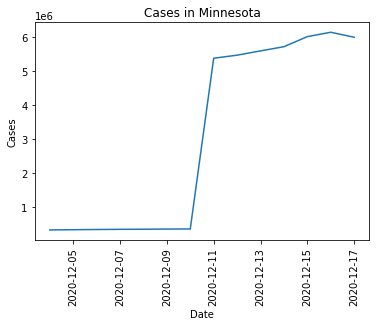

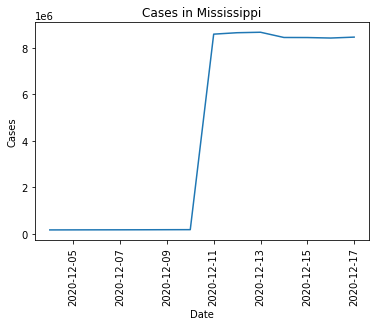

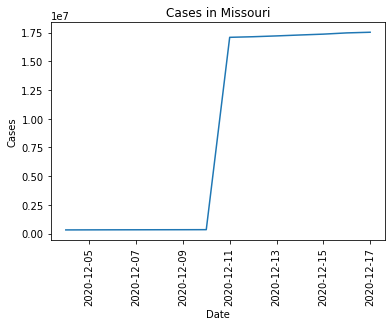

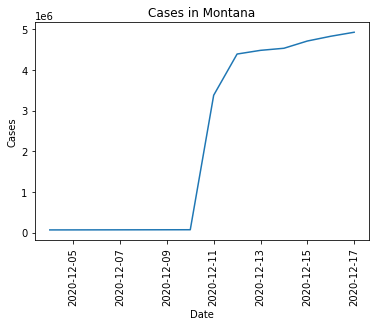

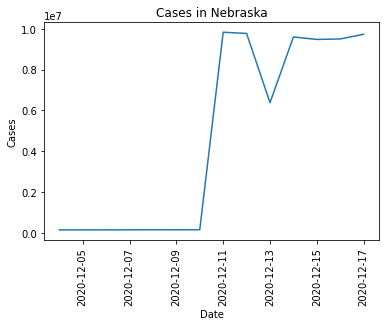

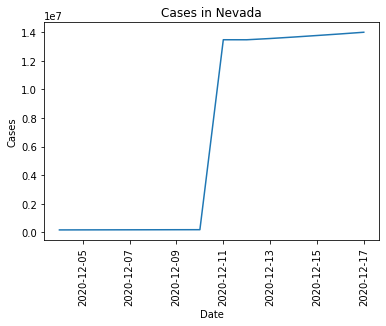

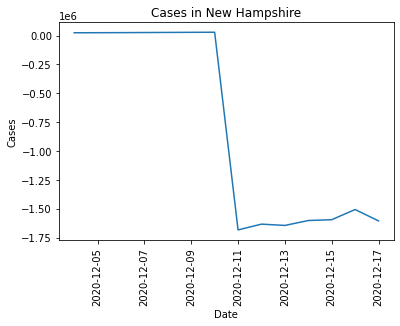

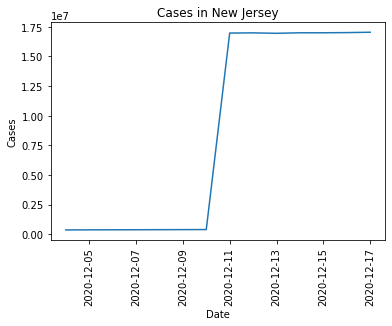

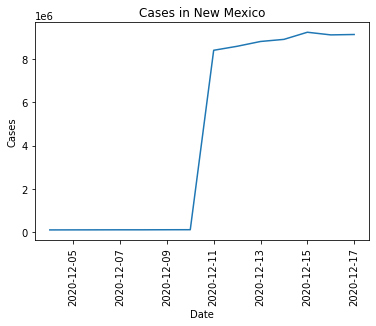

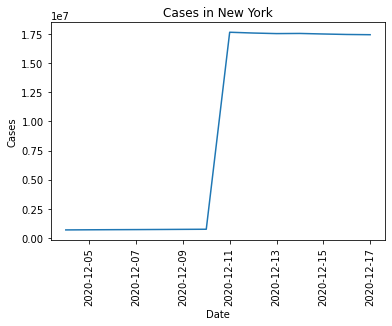

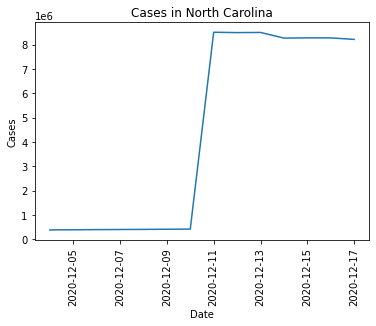

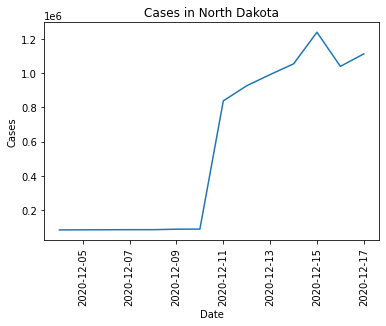

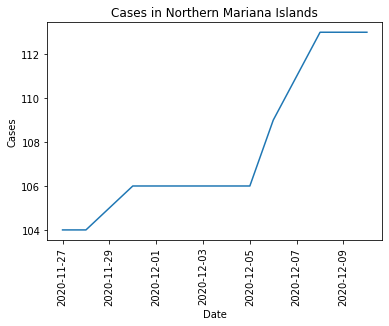

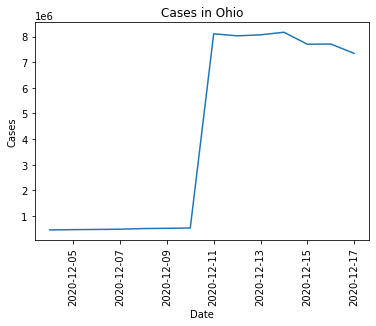

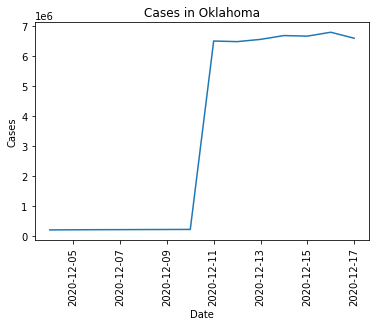

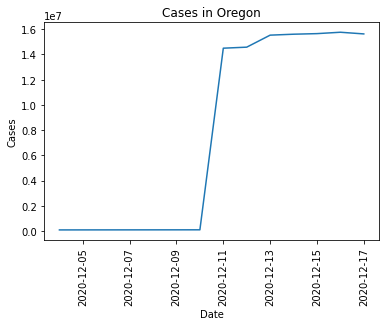

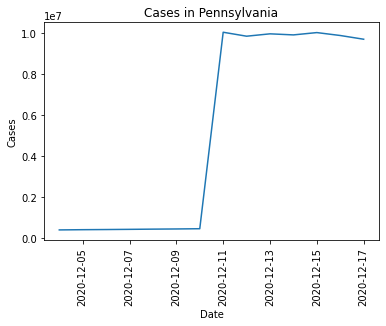

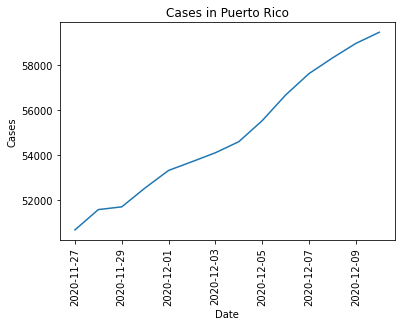

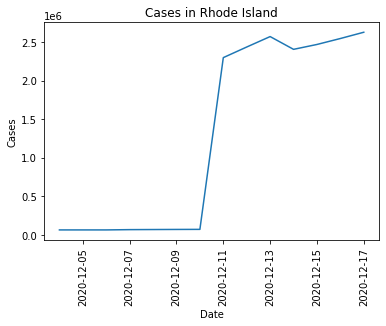

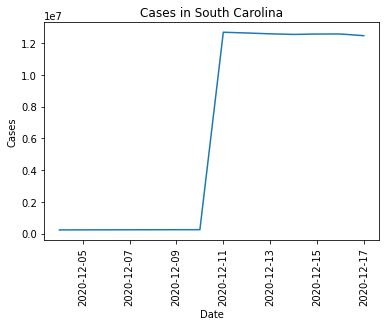

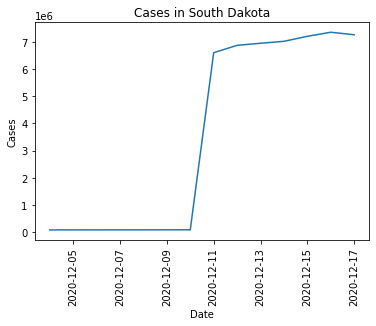

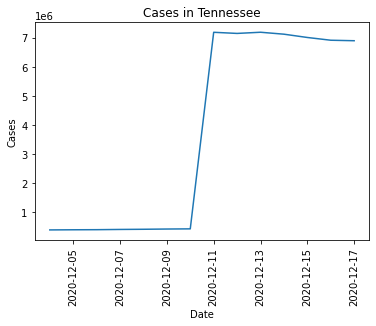

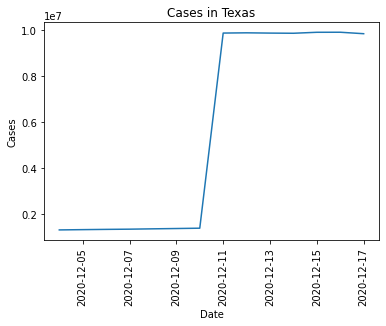

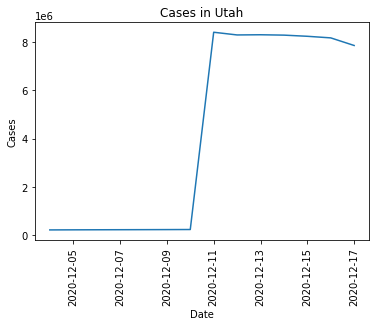

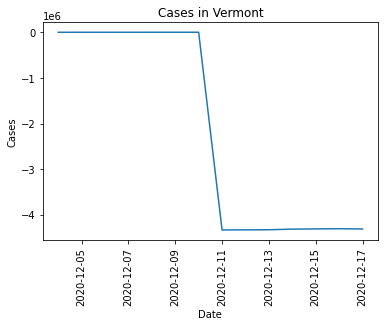

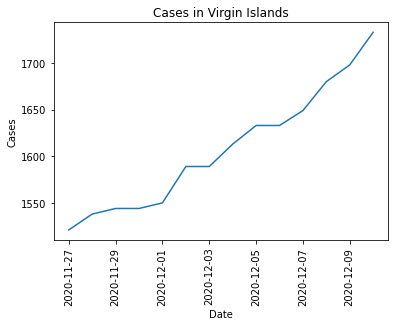

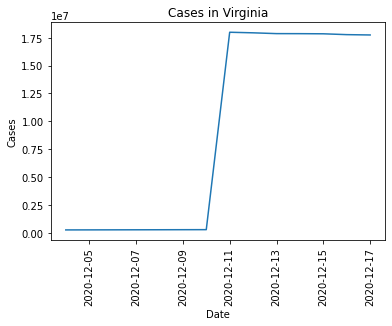

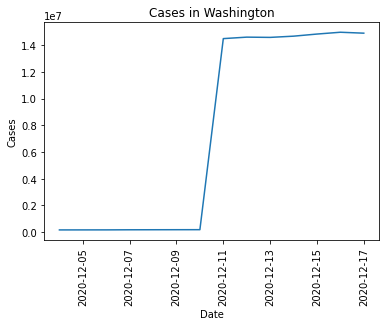

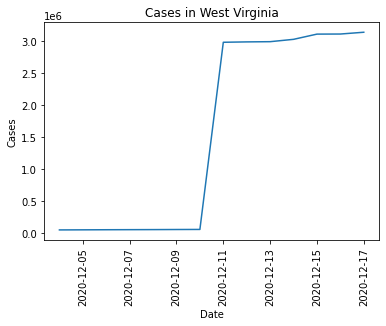

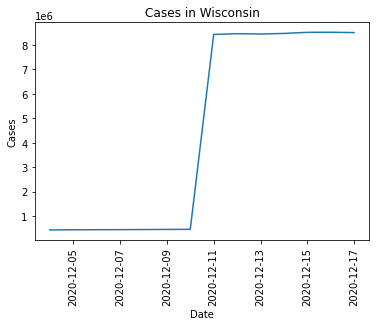

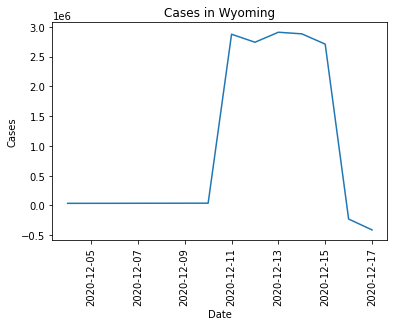

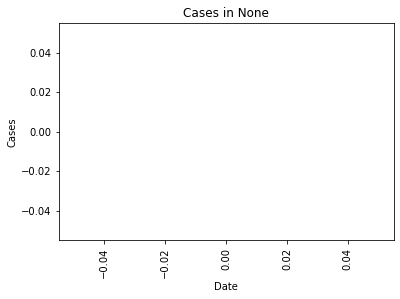

In [83]:
import matplotlib
import matplotlib.pyplot as plt
for state in final_df.state.unique():
    fig, ax = plt.subplots()
    ax.plot(final_df[final_df['state'] == state].date[-14:], final_df[final_df['state'] == state].cases[-14:])
    ax.set_xlabel('Date')
    ax.set_ylabel('Cases')
    plt.title('Cases in ' + str(state))
    plt.xticks(rotation = 90)
    plt.show()